# Cijfers
## Details
> Het  gebruik  van  cijfers  in  koppen  maakt  de  inhoud van het artikel voorspelbaar voor de lezers. Het geeft hen  zekerheid  waardoor  ze  weten  wat  ze  kunnen verwachten. Cijfers kunnen krantenkoppen interessanter  maken,  vooral  wanneer  het  gaat  om grote getallen (1). Ook kunnen cijfers inspelen op de gevoelens van mensen door bijvoorbeeld de leeftijd weer tegeven (2).
## Example
> (1) Iedereen dacht dat 313kinderen ziek werden door zijn lasagne, maar dat klopt niet: "Wat dan wél?"(2) Kranige  oma (93)bewijst  dat  er  op  angst overwinnen geen leeftijd staat

## Data

In [4]:
from util import get_cls_train_test

train_x, train_y, test_x, test_y = get_cls_train_test("Cijfers")
train_y.value_counts()

0    559
1    122
Name: Cijfers, dtype: int64

## Approach 1: Tf-idf
This will probably overfit on the numbers we've already seen

f-score: 0.4857142857142858
Confusion matrix: (TP: 175, FP: 6, FN: 30, TN: 17)
Accuracy=84.21% (192/228)


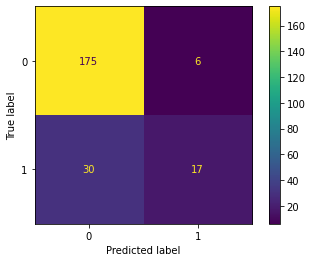

In [5]:
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm

from util import fit_predict_evaluate

model = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('resampler', SMOTETomek(random_state=0)),
    ('classifier', svm.LinearSVC(random_state=0))
])

fit_predict_evaluate(model, train_x, train_y, test_x, test_y)

In [6]:
from util import show_most_informative_features
show_most_informative_features(model)

2.7186           jaar    -0.7803           maar
2.2859            000    -0.6940           deze
2.1316           euro    -0.6653         meghan
1.5962         graden    -0.6162          heeft
1.5491             24    -0.5948          vrouw
1.4937            eén    -0.5763            dat
1.4067          meter    -0.5753           zien
1.3941             al    -0.5172           weer
1.3424        miljoen    -0.5133           gaat
1.3315          enige    -0.5102         gedaan


I didn't expect words like "jaar", "euro" or "graden" here, but it's quite a smart solution to the problem. Also "000" is interesting, since it get's seen as a seperate token in large number (because a "." means new token, e.g. 7.000.000 -> "7", "000" and "000").

## Approach 2: Char grams
Since a lot of number (e.g. "zevenhonderddrieëntwintig") consist of existing number, we can try to use char grams to predict whether there is a number. "Char-wb" stays between word boundries.

f-score: 0.5217391304347826
Confusion matrix: (TP: 177, FP: 4, FN: 29, TN: 18)
Accuracy=85.53% (195/228)


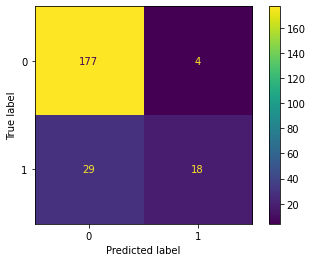

In [7]:
model = Pipeline([
    ('vectorizer', TfidfVectorizer(analyzer="char_wb", ngram_range=(1, 6))), # 2 e.g. -ig, 6 e.g. twaalf; 1 e.g. 1 (the number 1)
    ('resampler', SMOTETomek(random_state=0)),
    ('classifier', svm.LinearSVC(random_state=0))
])

fit_predict_evaluate(model, train_x, train_y, test_x, test_y)

In [8]:
show_most_informative_features(model, n=20)

2.6915              0    -0.5970             t 
1.6069              1    -0.5216             on
1.5240             0     -0.5142             ns
1.4168              2    -0.4811              o
1.3265             00    -0.4747              z
1.2748                   -0.4474              r
1.2497              (    -0.4133              '
1.2497              (    -0.4017             he
1.2497              )    -0.3977              g
1.1836              3    -0.3894             du
1.1315             )     -0.3822              n
1.0214              1    -0.3695            ns 
0.9975              2    -0.3679             sc
0.9817              4    -0.3666             ck
0.8864              5    -0.3600           maar
0.8856            00     -0.3574          maar 
0.8130           jaar    -0.3486            et 
0.8087           jaar    -0.3470              e
0.8022              7    -0.3466            sch
0.7967            jaa    -0.3442           maar


Previousely seen digits seem important. I have no explanation for the characters on the negative side. "Jaar" also stays something with a clear positive impact.

### Approach 3: Own function
Our function from earlier checks whether there is any digit or whether it contains a number as text (based on a list of known numbers). However as warned for earlier, this kind of functions are prone to overfitting, but I want to test it anyway to compare it with our char-gram model.

In [9]:
def contains_number_word(headline):
    # Note: I didn't write this entire list all by myself, it was suggested by GitHub Co-Pilot
    numbers = ["één", "twee", "drie", "vier", "vijf", "zes", "zeven", "acht", "negen", "tien", "elf", "twaalf",
               "dertien", "veertien", "vijftien", "zestien", "zeventien", "achttien", "negentien", "twintig", "dertig",
               "veertig", "vijftig", "zestig", "zeventig", "tachtig", "negentig", "honderd", "duizend", "miljoen",
               "miljard", "biljoen", "biljard",
               "triljoen"]  #, "triljard", "quadriljoen", "quadriljard", "quintiljoen", "quintiljard", "sextiljoen", "sextiljard", "septiljoen", "septiljard", "octiljoen", "octiljard", "noniljoen", "noniljard", "deciljoen", "deciljard", "undeciljoen", "undeciljard", "duodeciljoen", "duodeciljard", "tredeciljoen", "tredeciljard", "quattuordeciljoen", "quattuordeciljard", "quindeciljoen", "quindeciljard", "sexdeciljoen", "sexdeciljard", "septendeciljoen", "septendeciljard", "octodeciljoen", "octodeciljard", "novemdeciljoen", "novemdeciljard", "vigintiljoen", "vigintiljard", "unvigintiljoen", "unvigintiljard", "duovigintiljoen", "duovigintiljard", "trevigintiljoen", "trevigintiljard", "quattuorvigintiljoen", "quattuorvigintiljard", "quinquavigintiljoen", "quinquavigintiljard", "sexvigintiljoen", "sexvigintiljard", "septenvigintiljoen",
    headline = headline.lower().split()
    for number in numbers:
        if number in headline:
            return True
    return False


def contains_number(headline):
    # TODO? This doesn't check numbers written as text (e.g. "five")
    return any(char.isdigit() for char in headline)  # or contains_number_word(headline)

def contains_number_or_number_word(headline):
    return contains_number(headline) or contains_number_word(headline)

print(contains_number(
    "Iedereen dacht dat 313 kinderen ziek werden door zijn lasagne, maar dat klopt niet: \"Wat dan wél?\""))
print(contains_number("Kranige oma (93) bewijst dat er op angst overwinnen geen leeftijd staat"))

True
True


f-score: 0.8
Confusion matrix: (TP: 162, FP: 19, FN: 3, TN: 44)
Accuracy=90.35% (206/228)


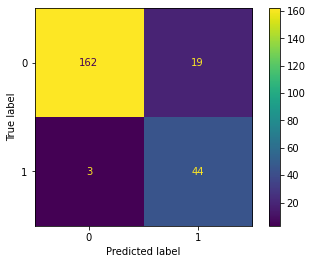

In [10]:
from util import print_evaluation
predict = test_x.apply(contains_number_or_number_word)
print_evaluation(test_y, predict)

This gives the best results.

## Approach 2: SpaCy
Maybe SpaCy can also detect numbers, let's see:

In [11]:
import spacy
from pprint import pprint

nlp = spacy.load('nl_core_news_sm')
pprint([(x.text, x.pos_, x.tag_) for x in nlp(u"Het getal acht kan ook geschreven worden als 8.")])

[('Het', 'DET', 'LID|bep|stan|evon'),
 ('getal', 'NOUN', 'N|soort|ev|basis|onz|stan'),
 ('acht', 'VERB', 'WW|pv|tgw|ev'),
 ('kan', 'AUX', 'WW|pv|tgw|ev'),
 ('ook', 'ADV', 'BW'),
 ('geschreven', 'VERB', 'WW|vd|vrij|zonder'),
 ('worden', 'AUX', 'WW|inf|vrij|zonder'),
 ('als', 'SCONJ', 'VG|onder'),
 ('8', 'NUM', 'TW|hoofd|vrij'),
 ('.', 'PUNCT', 'LET')]


It sees "acht" as a verb instead of a number, but "NUM" is also an option. Let's try another sentence:

In [12]:
pprint([(x.text, x.pos_, x.tag_) for x in nlp(u"Drie dagen geleden was het 7 augustus")])

[('Drie', 'NUM', 'TW|hoofd|prenom|stan'),
 ('dagen', 'NOUN', 'N|soort|mv|basis'),
 ('geleden', 'ADV', 'BW'),
 ('was', 'AUX', 'WW|pv|verl|ev'),
 ('het', 'PRON', 'VNW|pers|pron|stan|red|3|ev|onz'),
 ('7', 'NUM', 'TW|hoofd|vrij'),
 ('augustus', 'PROPN', 'N|eigen|ev|basis|zijd|stan')]


The numbers are now correctly recognized. Let's create a function for this:

In [13]:
def contains_number(headline):
    return any(x.pos_ == 'NUM' for x in nlp(headline))

f-score: 0.7777777777777777
Confusion matrix: (TP: 162, FP: 19, FN: 5, TN: 42)
Accuracy=89.47% (204/228)


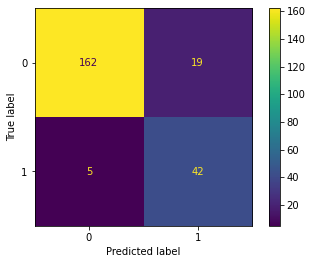

In [14]:
predictions = test_x.apply(contains_number)
print_evaluation(test_y, predictions)

This gives slightly worse results than the previous approach, but is probably safer for overfitting.